In [1]:
import glob
import subprocess
import matplotlib.pyplot as plt
import random
from utils import *
import cv2
from dataset_v2 import *
from network.model_v2 import *
import os
import sys
import time
import torch
import numpy as np
import torch.nn as nn
import tqdm
%load_ext autoreload
%autoreload 2


# Set testing profile

In [2]:
profile_wyw = dict(
    mesh_folder="",
    image_folder="",
    uv3d_folder="",

    obj_template_path="data/wyw_new/obj_template/01_000000.obj",
    uv3d_neutral_path="data/wyw_new/uv3d/01_000000.bin",

    tex_folder=None,
    tex1_folder=None,
    tex2_folder=None,

    tex_neutral_path="data/wyw_new/obj_template/00_000000.jpg",
    tex1_neutral_path=None,
    tex2_neutral_path=None,
)
profile = profile_wyw
comment = "20220420_wyw5_final"


In [3]:
comment_from = comment
device_train = torch.device("cuda:0")
batch_size = 1
num_workers = 0

dataset_render = MeshDataset(
    device=device_train,
    need_fake=False,
    need_real=True,
    need_uv3d=False,
    single_view=False,
    device_train=device_train,
    tex_size=512,
    **profile
)

In [10]:

checkpoint_dir = "saving"

net = ExpNet()
load_path = glob.glob(f"{checkpoint_dir}/{comment_from}*_latest*.pth")[-1]
print(load_path)
net.load(load_path)

net = net.to(device=device_train)
net.eval()
net.eps = 0

renderer_train = SimpleRenderer(device=device_train)


saving/20220420_wyw5_final_latest_1.pth
Dropping parameter render_real2.enc_content.model.0.conv.weight
Dropping parameter render_real2.enc_content.model.0.conv.bias
Dropping parameter render_real2.enc_content.model.1.conv.weight
Dropping parameter render_real2.enc_content.model.1.conv.bias
Dropping parameter render_real2.enc_content.model.2.model.0.model.0.conv.weight
Dropping parameter render_real2.enc_content.model.2.model.0.model.0.conv.bias
Dropping parameter render_real2.enc_content.model.2.model.0.model.1.conv.weight
Dropping parameter render_real2.enc_content.model.2.model.0.model.1.conv.bias
Dropping parameter render_real2.enc_content.model.2.model.1.model.0.conv.weight
Dropping parameter render_real2.enc_content.model.2.model.1.model.0.conv.bias
Dropping parameter render_real2.enc_content.model.2.model.1.model.1.conv.weight
Dropping parameter render_real2.enc_content.model.2.model.1.model.1.conv.bias
Dropping parameter render_real2.enc_content.model.2.model.2.model.0.conv.wei

# Load sample performance

In [5]:
face_latent_all_list = torch.tensor(np.load("face_latent_all_list.npy"), device=device_train)
face_latent_all_mean = torch.mean(face_latent_all_list, dim=0, keepdim=True)
face_latent_all_std = torch.std(face_latent_all_list, dim=0, keepdim=True)

# Generate a random expression

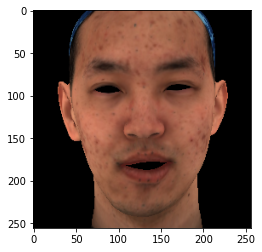

In [6]:
uv3d_mask = dataset_render.uv3d_mask_tensor.to(device=device_train)
uv3d_second_mask = dataset_render.uv3d_second_mask_tensor.to(device=device_train)

with torch.no_grad():
    face_latent_all = torch.randn(1, 512, device=device_train) * face_latent_all_std * 3 + face_latent_all_mean
    face_latent_all_expression = face_latent_all[:, :256]

    uv3d_both_pred_all = net.mesh_decoder(face_latent_all_expression)
    uv3d_pred_all = uv3d_both_pred_all[:, :3] * uv3d_mask
    uv3d_second_pred_all = uv3d_both_pred_all[:, 3:] * uv3d_second_mask

    tex_delta_pred_all = net.tex_decoder2(face_latent_all_expression)
    tex_pred_all = tex_delta_pred_all[:, :3] + dataset_render.tex_neutral
    tex_pred_all_diffuse = F.interpolate(tex_pred_all[:, :3], size=(256, 256), mode="bilinear", align_corners=False).detach()

    mesh_pred_all = uv3d_construct_mesh_2(dataset_render.obj_template2, uv3d_pred_all, uv3d_second_pred_all, uv3d_mask, uv3d_second_mask, only_mesh=True)
    mesh_pred_all.textures._maps_padded = while_map(tex_pred_all_diffuse.permute(0, 2, 3, 1), black=True)
    aug_static = torch.tensor([[0, 0, 0, 0, 0, 7, 1200, 1, 0, 0]], dtype=torch.float32, device=device_train)
    rendered_pred_static = renderer_train.render(mesh_pred_all, aug_static, crop=False, only_imgs=True)

line = 0
show_mesh_recon_rendered_wild_static = t2n(rendered_pred_static[line])

plt.imshow(show_mesh_recon_rendered_wild_static)


# Generate sample performance

In [7]:
os.makedirs(f"output", exist_ok=True)

for i, face_latent_all in enumerate(tqdm.tqdm(face_latent_all_list)):

    with torch.no_grad():

        face_latent_all = face_latent_all[None]

        face_latent_all_expression = face_latent_all[:, :256]
        face_latent_all_view = face_latent_all[:, 256:]

        uv3d_both_pred_all = net.mesh_decoder(face_latent_all_expression)
        uv3d_pred_all = uv3d_both_pred_all[:, :3] * uv3d_mask
        uv3d_second_pred_all = uv3d_both_pred_all[:, 3:] * uv3d_second_mask

        tex_delta_pred_all = net.tex_decoder2(face_latent_all_expression)
        tex_pred_all = tex_delta_pred_all[:, :3] + dataset_render.tex_neutral
        tex_pred_all_diffuse = F.interpolate(tex_pred_all[:, :3], size=(256, 256), mode="bilinear", align_corners=False).detach()

        mesh_pred_all = uv3d_construct_mesh_2(dataset_render.obj_template2, uv3d_pred_all, uv3d_second_pred_all, uv3d_mask, uv3d_second_mask, only_mesh=True)
        mesh_pred_all.textures._maps_padded = while_map(tex_pred_all_diffuse.permute(0, 2, 3, 1), black=True)
        aug_static = torch.tensor([[0, 0, 0, 0, 0, 7, 1200, 1, 0, 0]], dtype=torch.float32, device=device_train)
        rendered_pred_static = renderer_train.render(mesh_pred_all, aug_static, crop=False, only_imgs=True)

    cv2.imwrite(f"output/{i:06d}.png", t2n(rendered_pred_static[line])[:, :, ::-1] * 255)

subprocess.call(f"""ffmpeg -r 30 -pattern_type glob -i "output/*.png" -pix_fmt yuv420p output.mp4 -y -hide_banner -loglevel error""", shell=True)


100%|██████████| 300/300 [00:06<00:00, 43.01it/s]


0